In [2]:
import sys
from os.path import join,expanduser
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

user_home_dir = expanduser('~')
sys.path.append(join(user_home_dir,'ECCOv4-py'))
import ecco_v4_py as ecco
sys.path.append(join(user_home_dir,'ECCO-v4-Python-Tutorial'))

# Get grid info

In [3]:
# --- Load grid ---
ecco_grid = xr.open_dataset('/efs_ecco/ECCO/V4/r4/ECCO_L4_GEOMETRY_LLC0090GRID_V4R4/GRID_GEOMETRY_ECCO_V4r4_native_llc0090.nc')
ecco_grid.load()

<xarray.Dataset> Size: 89MB
Dimensions:  (i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_u: 50, k_l: 50,
              k_p1: 51, tile: 13, nb: 4, nv: 2)
Coordinates: (12/20)
  * i        (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * i_g      (i_g) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j        (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j_g      (j_g) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * k        (k) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * k_u      (k_u) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
    ...       ...
    Zp1      (k_p1) float32 204B 0.0 -10.0 -20.0 ... -5.678e+03 -6.134e+03
    Zu       (k_u) float32 200B -10.0 -20.0 -30.0 ... -5.678e+03 -6.134e+03
    Zl       (k_l) float32 200B 0.0 -10.0 -20.0 ... -5.244e+03 -5.678e+03
    XC_bnds  (tile, j, i, nb) float32 2MB -115.0 -115.0 -107.9 ... -115.0 -108.5
    YC_bnds  (tile, j, i, nb) float32 2MB -88.18 -88.32 -88.3 ... -88.18 -88.16
    Z_bnds   (k, nv) float32 400B 0.0 -10.0 -10.0 ... -5.678e+03 -6.134e+03
Dimensions without coordinates: nb, nv
Data variables: (12/21)
    CS       (tile, j, i) float32 421kB 0.06158 0.06675 ... -0.9854 -0.9984
    SN       (tile, j, i) float32 421kB -0.9981 -0.9978 ... -0.1705 -0.05718
    rA       (tile, j, i) float32 421kB 3.623e+08 3.633e+08 ... 3.611e+08
    dxG      (tile, j_g, i) float32 421kB 1.558e+04 1.559e+04 ... 2.314e+04
    dyG      (tile, j, i_g) float32 421kB 2.321e+04 2.327e+04 ... 1.558e+04
    Depth    (tile, j, i) float32 421kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ...       ...
    hFacC    (k, tile, j, i) float32 21MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    hFacW    (k, tile, j, i_g) float32 21MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    hFacS    (k, tile, j_g, i) float32 21MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    maskC    (k, tile, j, i) bool 5MB False False False ... False False False
    maskW    (k, tile, j, i_g) bool 5MB False False False ... False False False
    maskS    (k, tile, j_g, i) bool 5MB False False False ... False False False
Attributes: (12/58)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty and Ou Wang
    cdm_data_type:                   Grid
    comment:                         Fields provided on the curvilinear lat-l...
    Conventions:                     CF-1.8, ACDD-1.3
    coordinates_comment:             Note: the global 'coordinates' attribute...
    ...                              ...
    references:                      ECCO Consortium, Fukumori, I., Wang, O.,...
    source:                          The ECCO V4r4 state estimate was produce...
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    summary:                         This dataset provides geometric paramete...
    title:                           ECCO Geometry Parameters for the Lat-Lon...
    uuid:                            87ff7d24-86e5-11eb-9c5f-f8f21e2ee3e0

In [4]:
# --- Get the model grid variables ---
XC        = ecco_grid.XC.values # longitude (13x90x90) 
YC        = ecco_grid.YC.values # latitudes (13x90x90)
rA        = ecco_grid.rA.values # Also grid cell areaa in (m^2)(13x90x90)
maskC     = ecco_grid.maskC.values # 3d mask (0/1) for model grid (tracer point)
maskCSurf = maskC[0] # maskC at surface level (level = 1)
hFacC     = ecco_grid.hFacC.values # 3d non-dim factors (0-1) reflecing model cell geometry in vertical direction. Partial cells have values >0 but <1.
Zl        = ecco_grid.Zl.values # depth of vertical cell face: between 0 and -5678 meters
Z         = ecco_grid.Z.values # depth of vertical cell ceter: between -10 and -5906 meters
drF       = ecco_grid.drF.values # layer thickness (m); 1d with 50 elements

# More fields for the western and southern faces of grid cells. U is on the west face and V is on the southern face.
# They are the same as the fields above (C for tracer points at the center of grid cells).
# We need these fields for creating transport masks
maskW     = ecco_grid.maskW.values # 3d mask (0/1) for model grid (U point)
maskWSurf = maskW[0] # maskW at surface level (level = 1)
hFacW     = ecco_grid.hFacW.values 

maskS     = ecco_grid.maskS.values # 3d mask (0/1) for model grid (V point)
maskSSurf = maskS[0] # maskS at surface level (level = 1)
hFacS     = ecco_grid.hFacS.values 

# dxG and dyG are the horizontal grid spacing (meters) for the western and southern faces, respectively.
dxG       = ecco_grid.dxG.values
dyG       = ecco_grid.dyG.values

# Make masks and save to run directories

## North Face Mask

In [5]:
# --- Create North Face MASK --- 
tmS = np.zeros((50,13,90,90)) # For North Face, all flow is EAST/WEST
tmW = np.zeros((50,13,90,90)) #(k, tile, j, i)
tmW[18:40,10,77:81,42] = 1

areaW = dyG*hFacW*np.expand_dims(drF,axis=(1,2,3))
areaS = dxG*hFacS*np.expand_dims(drF,axis=(1,2,3))

dxG   = ecco_grid.dxG.data
dyG   = ecco_grid.dyG.data
drF   = ecco_grid.drF.data
hfacW = ecco_grid.hFacW.data
hfacS = ecco_grid.hFacS.data

trxWa = areaW*tmW
trxCa = trxWa
trxSa = areaS*tmS

In [6]:
# --- Save masks to p-cluster folders for adjoint runs ---
output_dir = '/home/jovyan/efs_ecco/lenders/north_mask_new_new'

trxWa_c  = ecco.llc_tiles_to_compact(trxWa)
trxWa_fn = f'trxWa_north_face.bin'
trxWa_c.astype('>f4').tofile(output_dir+'/'+trxWa_fn)

trxCa_c  = ecco.llc_tiles_to_compact(trxCa)
trxCa_fn = f'trxCa_north_face.bin'
trxCa_c.astype('>f4').tofile(output_dir+'/'+trxCa_fn)

trxSa_c  = ecco.llc_tiles_to_compact(trxSa)
trxSa_fn = f'trxSa_north_face.bin'
trxSa_c.astype('>f4').tofile(output_dir+'/'+trxSa_fn)

llc_tiles_to_faces: num_tiles,  13
llc_faces_to_compact: face 3 shape (50, 90, 90)
llc_faces_to_compact: data_compact array shape (50, 1170, 90)
llc_faces_to_compact: data_compact array shape (50, 1170, 90)
llc_faces_to_compact: data_compact array dtype float64
llc_tiles_to_faces: num_tiles,  13
llc_faces_to_compact: face 3 shape (50, 90, 90)
llc_faces_to_compact: data_compact array shape (50, 1170, 90)
llc_faces_to_compact: data_compact array shape (50, 1170, 90)
llc_faces_to_compact: data_compact array dtype float64
llc_tiles_to_faces: num_tiles,  13
llc_faces_to_compact: face 3 shape (50, 90, 90)
llc_faces_to_compact: data_compact array shape (50, 1170, 90)
llc_faces_to_compact: data_compact array shape (50, 1170, 90)
llc_faces_to_compact: data_compact array dtype float64


In [7]:
# --- Save masks locally folders for reference ---
output_dir = '/home/jovyan/proj_folder/ESS25-Team_PUFFIN/data/'

trxWa_c  = ecco.llc_tiles_to_compact(trxWa)
trxWa_fn = f'trxWa_north_face.bin'
trxWa_c.astype('>f4').tofile(output_dir+'/'+trxWa_fn)

trxCa_c  = ecco.llc_tiles_to_compact(trxCa)
trxCa_fn = f'trxCa_north_face.bin'
trxCa_c.astype('>f4').tofile(output_dir+'/'+trxCa_fn)

trxSa_c  = ecco.llc_tiles_to_compact(trxSa)
trxSa_fn = f'trxSa_north_face.bin'
trxSa_c.astype('>f4').tofile(output_dir+'/'+trxSa_fn)

llc_tiles_to_faces: num_tiles,  13
llc_faces_to_compact: face 3 shape (50, 90, 90)
llc_faces_to_compact: data_compact array shape (50, 1170, 90)
llc_faces_to_compact: data_compact array shape (50, 1170, 90)
llc_faces_to_compact: data_compact array dtype float64
llc_tiles_to_faces: num_tiles,  13
llc_faces_to_compact: face 3 shape (50, 90, 90)
llc_faces_to_compact: data_compact array shape (50, 1170, 90)
llc_faces_to_compact: data_compact array shape (50, 1170, 90)
llc_faces_to_compact: data_compact array dtype float64
llc_tiles_to_faces: num_tiles,  13
llc_faces_to_compact: face 3 shape (50, 90, 90)
llc_faces_to_compact: data_compact array shape (50, 1170, 90)
llc_faces_to_compact: data_compact array shape (50, 1170, 90)
llc_faces_to_compact: data_compact array dtype float64


## West Face Mask

In [24]:
# --- Create North Face MASK --- 
tmS = np.zeros((50,13,90,90)) # For West Face, all flow is NORTH/SOOUTH
tmW = np.zeros((50,13,90,90)) #(k, tile, j, i)
tmS[25:50,10,72,49:54] = 1

trxSa = areaS*tmS
trxCa = trxSa
trxWa = areaW*tmW

In [25]:
# --- Save masks to p-cluster folders for adjoint runs ---
output_dir = '/home/jovyan/efs_ecco/lenders/east_mask_new/'

trxWa_c  = ecco.llc_tiles_to_compact(trxWa)
trxWa_fn = f'trxWa_east_face.bin'
trxWa_c.astype('>f4').tofile(output_dir+'/'+trxWa_fn)

trxCa_c  = ecco.llc_tiles_to_compact(trxCa)
trxCa_fn = f'trxCa_east_face.bin'
trxCa_c.astype('>f4').tofile(output_dir+'/'+trxCa_fn)

trxSa_c  = ecco.llc_tiles_to_compact(trxSa)
trxSa_fn = f'trxSa_east_face.bin'
trxSa_c.astype('>f4').tofile(output_dir+'/'+trxSa_fn)

llc_tiles_to_faces: num_tiles,  13
llc_faces_to_compact: face 3 shape (50, 90, 90)
llc_faces_to_compact: data_compact array shape (50, 1170, 90)
llc_faces_to_compact: data_compact array shape (50, 1170, 90)
llc_faces_to_compact: data_compact array dtype float64


PermissionError: [Errno 13] Permission denied: '/home/jovyan/efs_ecco/lenders/east_mask_new//trxWa_east_face.bin'

In [26]:
# --- Save masks locally folders for reference ---
output_dir = '/home/jovyan/proj_folder/ESS25-Team_PUFFIN/data/'

trxWa_c  = ecco.llc_tiles_to_compact(trxWa)
trxWa_fn = f'trxWa_east_face.bin'
trxWa_c.astype('>f4').tofile(output_dir+'/'+trxWa_fn)

trxCa_c  = ecco.llc_tiles_to_compact(trxCa)
trxCa_fn = f'trxCa_east_face.bin'
trxCa_c.astype('>f4').tofile(output_dir+'/'+trxCa_fn)

trxSa_c  = ecco.llc_tiles_to_compact(trxSa)
trxSa_fn = f'trxSa_east_face.bin'
trxSa_c.astype('>f4').tofile(output_dir+'/'+trxSa_fn)

llc_tiles_to_faces: num_tiles,  13
llc_faces_to_compact: face 3 shape (50, 90, 90)
llc_faces_to_compact: data_compact array shape (50, 1170, 90)
llc_faces_to_compact: data_compact array shape (50, 1170, 90)
llc_faces_to_compact: data_compact array dtype float64
llc_tiles_to_faces: num_tiles,  13
llc_faces_to_compact: face 3 shape (50, 90, 90)
llc_faces_to_compact: data_compact array shape (50, 1170, 90)
llc_faces_to_compact: data_compact array shape (50, 1170, 90)
llc_faces_to_compact: data_compact array dtype float64
llc_tiles_to_faces: num_tiles,  13
llc_faces_to_compact: face 3 shape (50, 90, 90)
llc_faces_to_compact: data_compact array shape (50, 1170, 90)
llc_faces_to_compact: data_compact array shape (50, 1170, 90)
llc_faces_to_compact: data_compact array dtype float64


# Check Masks

In [20]:
import sys
import os
sys.path.append(os.path.abspath('../scripts'))
from proj_utils import *
from mapping_utils import *
import matplotlib.patches as patch

In [16]:
user_home_dir = expanduser('~')
fig_path      = '../figures'

In [17]:
# --- Pull json files (borrowed from ecco-summer-school.github.io tutorials) ---
s3, credentials = init_S3FileSystem(use_earthdata=False, requester_pays=True)
mzz_local_directory = Path('/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native')

#np.sort(list(mzz_local_directory.glob('*json')))

mzz_local_file= mzz_local_directory / 'OCEAN_VELOCITY_mon_mean_native_llc090_ECCOV4r5.json'

fs = fsspec.filesystem("reference",     
                       fo=str(mzz_local_file),
                       remote_protocol="s3",
                       remote_options={"anon":False, "requester_pays":True},
                       skip_instance_cache=True)
# 
fs.asynchronous = True
store = zarr.storage.FsspecStore(fs)
ds = xr.open_dataset(store, engine='zarr',
                     consolidated=False, chunks={'time':4, 'Z':50})

In [18]:
# --- Compute masked u velocity across north face ---
uvel_mean = ds.UVEL.mean(dim = 'time').compute()
masked_u  = uvel_mean*trxWa
masked_u  = masked_u.sel(tile = 10)
masked_u  = masked_u.sel(j = slice(71.75,84.25),i_g = slice(41.75,54.25))
masked_u  = masked_u.sel(i_g = slice(masked_u.i_g[0])).squeeze()

/tmp/ipykernel_1299/51675421.py:9: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = plt.colorbar()


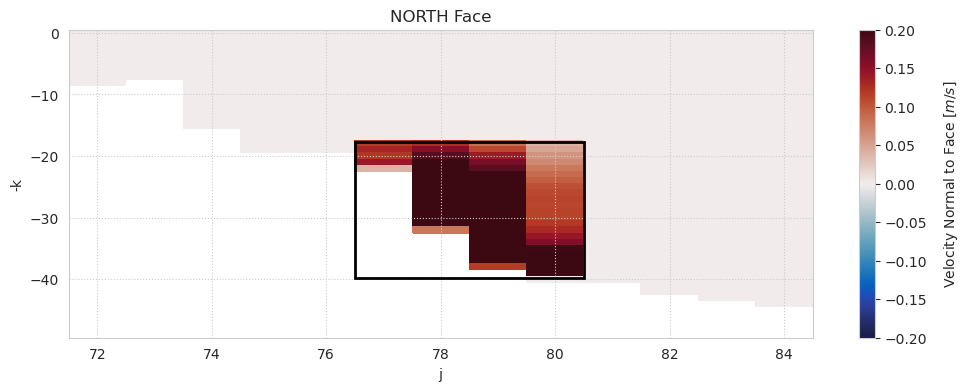

In [21]:
# --- Plot section of masked u velocity across north face ---
sv_name = '/point_wise_mn_north_flux_masked'
sns.set_style('whitegrid',{"grid.linestyle": ":"})
fig, ax = plt.subplots(figsize=[12,4])
levels = np.linspace(-0.15,0.50,41)

plt.pcolor(masked_u.j,-masked_u.k,masked_u/1e6,cmap='cmo.balance',vmin = -0.2, vmax = 0.2,zorder = 0)

plt.title('NORTH Face')
cbar = plt.colorbar()
cbar.set_label('Velocity Normal to Face [$m/s$]',  labelpad=11)
plt.xlabel('j')
plt.ylabel('-k')
ax.add_patch(patch.Rectangle((76.5,-39.75),4,22,facecolor='None',edgecolor='k',linewidth=2))
plt.savefig(fig_path + sv_name + '.png', format='png', bbox_inches="tight",dpi=500)


In [28]:
# --- Compute masked v velocity across west face ---
vvel_mean = ds.VVEL.mean(dim = 'time').compute()
masked_v = vvel_mean*trxSa
masked_v = masked_v.sel(tile = 10)
masked_v = masked_v.sel(j_g = slice(71.75,84.25),i = slice(41.75,54.25))
masked_v = masked_v.sel(j_g = slice(masked_v.j_g[0])).squeeze()

/tmp/ipykernel_1299/3858861012.py:10: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = plt.colorbar()


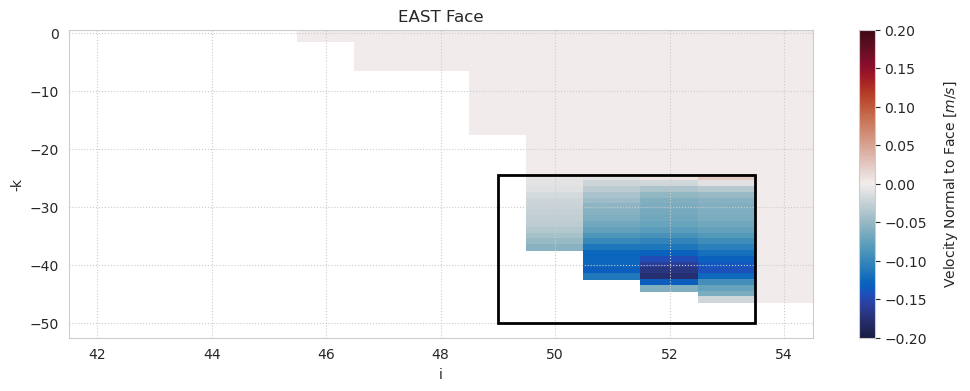

In [29]:
# --- Plot section of masked v velocity across west face ---
sv_name = '/point_wise_mn_east_flux_masked'
sns.set_style('whitegrid',{"grid.linestyle": ":"})
fig, ax = plt.subplots(figsize=[12,4])
levels = np.linspace(-0.15,0.50,41)

plt.pcolor(masked_v.i,-masked_v.k,masked_v/1e6,cmap='cmo.balance',vmin = -0.2, vmax = 0.2,zorder = 0)

plt.title('EAST Face')
cbar = plt.colorbar()
cbar.set_label('Velocity Normal to Face [$m/s$]',  labelpad=11)
plt.xlabel('i')
plt.ylabel('-k')
ax.add_patch(patch.Rectangle((49,-50),4.5,25.5,facecolor='None',edgecolor='k',linewidth=2))
plt.savefig(fig_path + sv_name + '.png', format='png', bbox_inches="tight",dpi=500)
